# Fluid Simulation with Cosmic Rays

## Imports

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jf1uids.option_classes.simulation_config import SPHERICAL
from jf1uids import SimulationConfig
from jf1uids import SimulationParams
from jf1uids import get_helper_data
from jf1uids.fluid_equations.fluid import construct_primitive_state
from jf1uids import get_registered_variables
from jf1uids.option_classes.simulation_config import finalize_config


from jf1uids import time_integration

## Simulation Setup

Let us set up a very simple simulation, mostly with default parameters - except for the inclusion of Cosmic Rays.

In [2]:
from jf1uids._physics_modules._cosmic_rays.cosmic_ray_options import CosmicRayConfig
from jf1uids.option_classes.simulation_config import CARTESIAN, HLL

config = SimulationConfig(
    geometry = CARTESIAN,
    num_cells = 5001,
    box_size = 10.0,
    cosmic_ray_config = CosmicRayConfig(cosmic_rays = True, diffusive_shock_acceleration = False),
    riemann_solver = HLL
)

Next we setup the simulation parameters, things we might vary

In [3]:
from jf1uids._physics_modules._cosmic_rays.cosmic_ray_options import CosmicRayParams


params = SimulationParams(
    t_end = 0.35,
    cosmic_ray_params = CosmicRayParams(
        diffusive_shock_acceleration_efficiency = 0.5
    )
)

With this we generate some helper data, like the cell centers etc.

In [4]:
helper_data = get_helper_data(config)
registered_variables = get_registered_variables(config)

Next we setup the shock initial conditions

In [5]:
shock_pos = 5.0
r = helper_data.geometric_centers
rho = jnp.where(r < shock_pos, 1.0, 0.125)
u = jnp.zeros_like(r)
p_gas = jnp.where(r < shock_pos, 63.499, 0.1)

# cosmic ray setup
p_cr = jnp.where(r < shock_pos, 0.0, 0.0)
gamma_cr = 4/3
n_cr = p_cr ** (1/gamma_cr)

# get initial state
initial_state = construct_primitive_state(
    registered_variables = registered_variables,
    config = config,
    density = rho,
    velocity_x = u,
    gas_pressure = p_gas,
    cosmic_ray_pressure = p_cr
)

config = finalize_config(config, initial_state.shape)

Automatically setting open boundaries for Cartesian geometry.


## Running the simulation

In [6]:
final_state = time_integration(initial_state, config, params, helper_data, registered_variables)
rho_final = final_state[registered_variables.density_index]
u_final = final_state[registered_variables.velocity_index]
p_final = final_state[registered_variables.pressure_index]
n_cr_final = final_state[registered_variables.cosmic_ray_n_index]
p_cr_final = n_cr_final ** gamma_cr
p_gas_final = p_final - p_cr_final

## Visualization

RegisteredVariables(num_vars=4, density_index=0, velocity_index=1, magnetic_index=-1, pressure_index=2, wind_density_index=-1, wind_density_active=False, cosmic_ray_n_index=3, cosmic_ray_n_active=True)


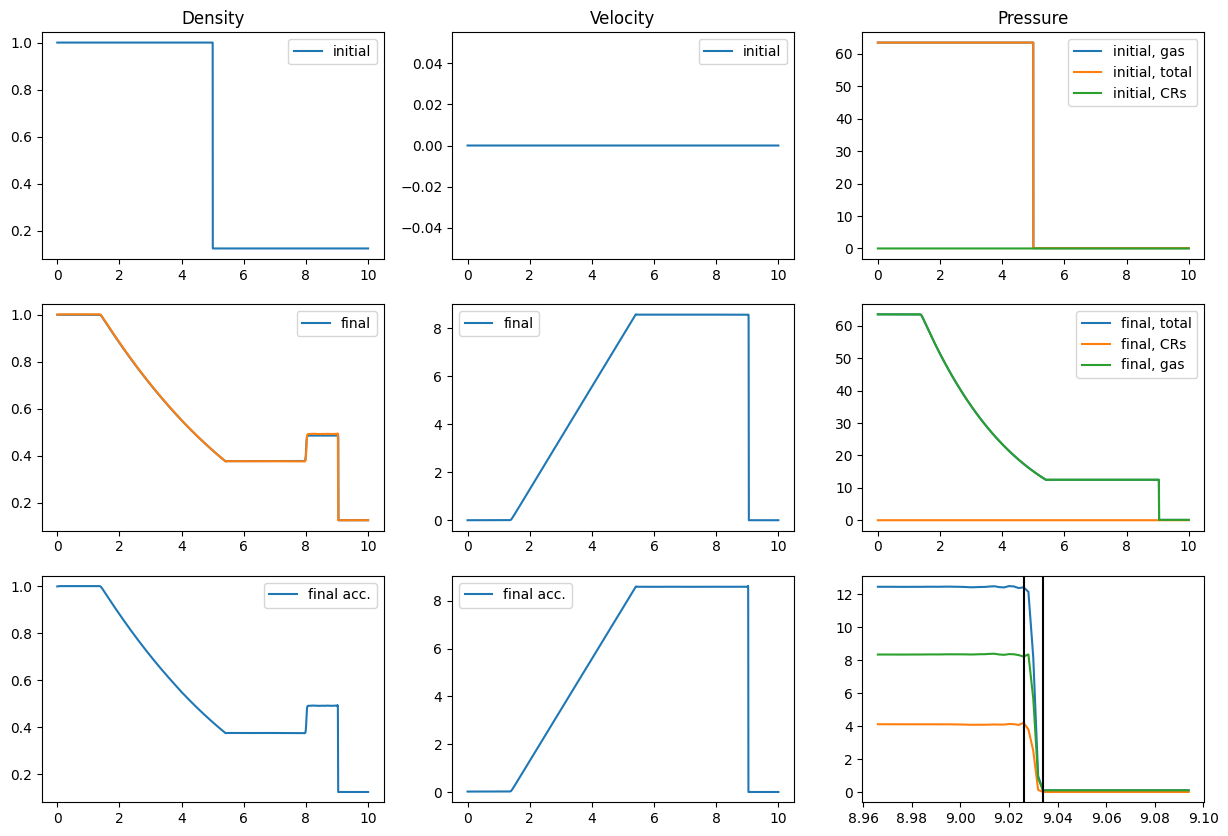

In [7]:
from jf1uids.shock_finder.shock_finder import find_shock_zone


fig, axs = plt.subplots(3, 3, figsize=(15, 10))

axs[0, 0].plot(r, rho, label='initial')
axs[1, 0].plot(r, rho_final, label='final')
axs[0, 0].set_title('Density')
axs[0, 0].legend()
axs[1, 0].legend()

axs[0, 1].plot(r, u, label='initial')
axs[1, 1].plot(r, u_final, label='final')
axs[0, 1].set_title('Velocity')
axs[0, 1].legend()
axs[1, 1].legend()

axs[0, 2].plot(r, p_gas, label='initial, gas')
axs[0, 2].plot(r, p_gas + p_cr, label='initial, total')
axs[1, 2].plot(r, p_final, label='final, total')
axs[0, 2].plot(r, p_cr, label='initial, CRs')
axs[1, 2].plot(r, p_cr_final, label='final, CRs')
axs[1, 2].plot(r, p_gas_final, label='final, gas')

axs[0, 2].set_title('Pressure')
axs[0, 2].legend()
axs[1, 2].legend()

config2 = config._replace(cosmic_ray_config=CosmicRayConfig(cosmic_rays=True, diffusive_shock_acceleration=True))

config2 = finalize_config(config2, initial_state.shape)

final_state_acc = time_integration(initial_state, config2, params, helper_data, registered_variables)
rho_final_acc = final_state_acc[registered_variables.density_index]
u_final_acc = final_state_acc[registered_variables.velocity_index]
p_final_acc = final_state_acc[registered_variables.pressure_index]
n_cr_final_acc = final_state_acc[registered_variables.cosmic_ray_n_index]
p_cr_final_acc = n_cr_final_acc ** gamma_cr
p_gas_final_acc = p_final_acc - p_cr_final_acc

axs[2, 0].plot(r, rho_final_acc, label='final acc.')
axs[1, 0].plot(r, rho_final_acc, label='final acc.')

axs[2, 1].plot(r, u_final_acc, label='final acc.')

_, left_idx, right_idx = find_shock_zone(final_state_acc[registered_variables.pressure_index], final_state_acc[registered_variables.velocity_index])
a = r[left_idx] - 0.06
b = r[right_idx] + 0.06

axs[2, 2].plot(r[(r > a) & (r < b)], p_final_acc[(r > a) & (r < b)], label='final acc., total')
axs[2, 2].plot(r[(r > a) & (r < b)], p_cr_final_acc[(r > a) & (r < b)], label='final acc., CRs')
axs[2, 2].plot(r[(r > a) & (r < b)], p_gas_final_acc[(r > a) & (r < b)], label='final acc., gas')

# axs[2, 2].plot(r, p_final_acc, label='final acc., total')
# axs[2, 2].plot(r, p_cr_final_acc, label='final acc., CRs')
# axs[2, 2].plot(r, p_gas_final_acc, label='final acc., gas')

_, left_idx, right_idx = find_shock_zone(final_state_acc[registered_variables.pressure_index], final_state_acc[registered_variables.velocity_index])
axs[2, 2].axvline(r[left_idx], color='black')
axs[2, 2].axvline(r[right_idx], color='black')

axs[2, 0].legend()
axs[2, 1].legend()

print(registered_variables)
